# Explanation : RKMK Solvers for Rotations in Exponential Coordinates

This notebook distinguishes RKMK solvers from traditional RK solvers.  The use of fixed-step solvers are illustrates for rotations in exponential coordinates.

Kinematic equations governing changes in vehicle states are typically expressed as ordinary differential equations (ODEs).  In this sense, navigators are simply numerical approaches to solving initial-value problems (IVPs) on the kinematic ODEs. For rotation groups, the governing ODEs depend on the choice of coordinates. In this tutorial we focus on exponential coordinates and the extension of Runge-Kutta (RK) methods - known as Runge-Kutta Munthe-Kaas (RKMK) methods - to solve the rotation IVP in exponential coordinates.


```{contents} Table of Contents
:depth: 3
```

In [1]:
import sys, os

sys.path.insert(0, os.path.join("..", "..", ".."))

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp as scipy_solve
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial

# from hitman.lie import LieExponential.exp, LieExponential.log, LieExponential.J_l, LieExponential.hat, LieExponential.vee
from hitman.rotation import LieExponential as SO
from hitman.ode import (
    rk_fixed,
    rkmk_fixed,
    butcher_tableaux,
    verify_ivp_solve,
    bortz_equation,
)

## Solving ODEs Using Runge Kutta Methods

Before attacking differential equations on rotational groups, we first consider a simple time-invariant ODE. We illustrate the relationship between solver order & step size while demonstrating methods to quantify errors.

### Solver Order and Butcher Tableaux

Solver order affects solution accuracy, particularly as the step size increases. To illustrate the point, we define a dictionary of RK ODE solvers with varying order. Solver order is determined by the Butcher tableau {cite}`butcherNumericalMethodsOrdinary2016`. The dictionary is effectively a solver factory. The dictionary key indicates the tableau (solver order) and the value is a functional. Each functional implementation shares the same function syntax.

We primarily focuse on fixed step-size solvers. However, for now we will include a variable step size solver {py:func}`scipy.integrate.solve_ivp` as an additional reference solution.

In [2]:
# Create dictionary of ode solvers
rk_solver_dict = {}
tableau = ["FwdElr", "ExpMid", "RK3", "RK4", "Variable"]
for tableau_ in tableau:
    # Define solver for this tableau
    def ivp_solve(ode, t, step_size, y_t, tableau=tableau_) -> np.ndarray:
        if tableau in butcher_tableaux:

            y = rk_fixed(ode, t, step_size, y_t, tableau=butcher_tableaux[tableau])
        else:
            # Unknown tableau, use scipy built-in solver (variable step-size)
            t_end = t + step_size
            rslt = scipy_solve(
                ode, np.array([t, t_end]), np.array([y_t]), t_eval=np.array([t_end])
            )
            y = rslt.y

        return y

    rk_solver_dict[tableau_] = ivp_solve

### Quantifying Solver Perforformance

We define one utility function to quantify solver performance and one to visualize results.

In [3]:
def quantify_solver(
    ode: Callable[[float, np.ndarray], np.ndarray],
    solution: Callable[[float], np.ndarray],
    solver_dict: dict,
    t: np.ndarray = np.random.uniform(0, 1, 10),
    step_size: np.ndarray = np.logspace(-8, -1, num=15),
) -> pd.DataFrame:
    r"""Quantify solver performance

    Randomly sample solution in time and quantify solver error while varying step size

    Args:
       ode: Ordinary differential equation: $f(t,y) : \mathbb{R} \times
       \mathbb{R}^n\rightarrow\mathbb{R}^n$
       solution: $y(t) : \mathbb{R} \rightarrow\mathbb{R}^n$
       solver_dict: Dictionary of solvers to evaluate
       t : selection of start times over which to average results
       step_size : step sizes to evaluate

    Returns:
        Average error over step size for each solver
    """

    # Initialize a dictionary to store average errors for each tableau
    errors_dict = {}
    for name, ivp_solve in solver_dict.items():
        # Compute average error for each step size
        err, _ = verify_ivp_solve(
            ode,
            solution,
            t,
            step_size,
            solver=ivp_solve,
        )
        errors_dict[name] = err

    return pd.DataFrame(errors_dict, index=step_size)


def plot_solver_performance(df, title="ODE solver error for RK methods"):
    # Plot the result
    for tableau_ in df.columns:
        plt.loglog(df.index, df[tableau_], label=tableau_)
    # Add labels and title
    plt.xlabel("Step Size (step_size)")
    plt.ylabel("Average Error")
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

### Example Trajectory: Time-Invariant ODE
Define an example ODE with known solution. In this case, the ODE is time-invariant

$$ \dot{y} = y $$

with a solution

$$ y(t) = C e^t $$

In [4]:
# Define the ODE and solution
class OdeExponential:
    def __init__(self, C: float = 0.1):
        self.C = C

    def sol(self, t):
        return self.C * np.exp(t)

    def ode(self, t, y):
        return y

Our example ODE and solution can be used to quantify solver performance using the functions above.

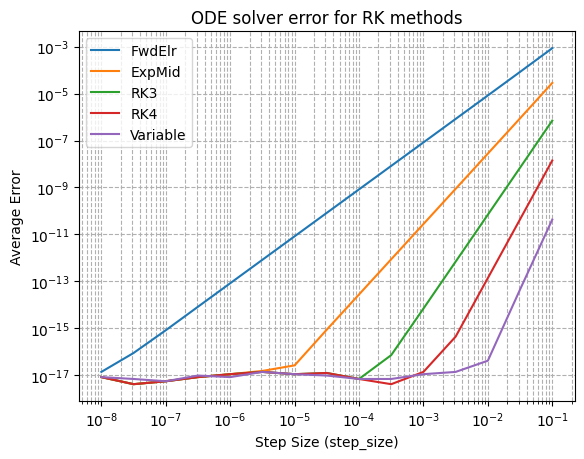

In [5]:
ref_ode = OdeExponential()
ode = ref_ode.ode
solution = ref_ode.sol
solver_dict = rk_solver_dict

df = quantify_solver(ode, solution, solver_dict)
plot_solver_performance(df)

### Binary Metrics for Unit Tests
Considering a specific step size (1e-2 in this case), we should see a significant difference between solver accuracy with order. Additionally, error should be small for the highest order solver (RK4).

In [6]:
# Display the DataFrame with log10 of the index
dfd = df.copy()
dfd.index = np.log10(dfd.index)
display(dfd)

# Contrast performance at specific tau
tau_pick = 1e-2
tol = -2  # expected error magnitude reduction with step-size
mask = df.index == tau_pick
assert np.count_nonzero(mask) == 1, (
    "Exactly one true value expected. %g is not a valid index" % tau_pick
)
row = df.loc[mask]
log_row = row.map(np.log10)
assert np.all(np.diff(log_row) < tol), "Errors did not decrease as expected"

tableau = "RK4"
tol = 1e-11
err = row.loc[tau_pick, tableau]
assert err < tol, "Absolute error exceeds expected: %.2e, for %s with step size %g." % (
    err,
    tableau,
    tau_pick,
)

,FwdElr,ExpMid,RK3,RK4,Variable
-8.0,1.387779e-17,8.326673e-18,8.326673e-18,8.326673e-18,8.326673e-18
-7.5,8.881784e-17,4.163336e-18,4.163336e-18,4.163336e-18,6.938894e-18
-7.0,8.257284e-16,5.551115e-18,5.551115e-18,5.551115e-18,5.551115e-18
-6.5,8.291978e-15,8.326673e-18,8.326673e-18,8.326673e-18,9.714451e-18
-6.0,8.297391e-14,1.110223e-17,1.110223e-17,1.110223e-17,8.326673e-18
-5.5,8.297141e-13,1.526557e-17,1.387779e-17,1.387779e-17,1.387779e-17
-5.0,8.297057e-12,2.636780e-17,1.110223e-17,1.110223e-17,1.110223e-17
-4.5,8.297118e-11,8.798517e-16,1.249001e-17,1.249001e-17,9.714451e-18
-4.0,8.297307e-10,2.765843e-14,6.938894e-18,6.938894e-18,6.938894e-18
-3.5,8.297905e-09,8.746573e-13,7.216450e-17,4.163336e-18,6.938894e-18


## Solving ODEs on Rotational Groups
Rotations are often expressed as a matrix $R\in SO(3)$. Specifying differential equations in $SO(3)$ is not convenient since $SO(3)$ is inherently three dimensional. In the following we motivate specifying the ODE in exponential coordinates. Once we define the ODE and a numeric solution, we can apply traditional RK solvers and assess accuracy. Finally, we will demonstrate RKMK solvers which operate on a function rather than the ODE directly.

### ODE For Rotational Groups
Consider the attitude trajectory

$$ R(t) = R(t-\tau)\Delta R(\tau) $$

where $\Delta R, R \in SO(3)$. Since $SO(3)$ is inherently three dimensional, $\Delta R$ admits prameterization in a three-dimensional space. Using exponential coordinates $\phi\in \mathbb{R}^3$, we have

$$ \Delta R(\tau) = \exp(\phi(\tau)\wedge) $$

The differential expression for $\dot{\phi}$ depends on the independent variable $\phi$ and a time-varying function $\omega : \mathbb{R}\rightarrow\mathbb{R}^3$

$$ 
\dot{\phi} = J_\phi^{-1}\omega 
$$

Here, $J_\phi^{-1}\in GL(3)$ is the inverse Jacobian of the exponential mapping. For any $\phi\in\mathbb{R}^3$, $J$ is a $3\times3$ invertible matrix. 

We seek the solution to the initial value problem $\phi(\tau)$ given $\phi(0) = 0$ governed by the ODE above. Ignoring phase wrapping (assuming $\| \phi \|< \pi$), this is equivalent to solving $ \Delta R$ given $R(t-\tau)$.

### Example Trajectory: Exponential Coordinates
Here we define the trajectory by specifying $\phi : \mathbb{R}\rightarrow\mathbb{R}^3$ as a polynomial curve. Note, this requires $\| \phi \|< \pi$ for all $t$ to avoid phase wrapping.

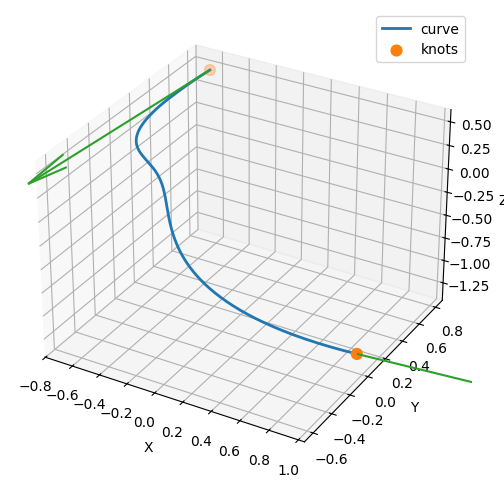

In [7]:
from scipy.interpolate import BPoly
from hitman.plot import plot_hermite_spline

random_matrix = np.random.randn(5, 3)
assert (
    np.max(np.linalg.norm(random_matrix, axis=1)) < np.pi
), "Curve control points must lie within a sphere with radius pi."

poly_phi = BPoly(random_matrix[:, np.newaxis, :], [0.0, 1.0])

_, _ = plot_hermite_spline(poly_phi)

Evaluating $\omega$ requires both $\phi$ and $\dot{\phi}$ which are available analytically.

In [ ]:
def eval_omega(t, phi=poly_phi, phidot=poly_phi.derivative(1)):
    """Omega function

    :param t: N-vector of timesteps
    :return: Nx3 matrix of omega(t)
    """
    return SO.J_r(phi(t)) @ phidot(t)


bortz_ode = partial(bortz_equation, omega=eval_omega)
solution_bortz = poly_phi

### Runge-Kutta Methods for Rotation Groups

The same RK solvers can be applied to differential equations on the exponential coordinates. We expect similar improvement in solution quality with solver order.

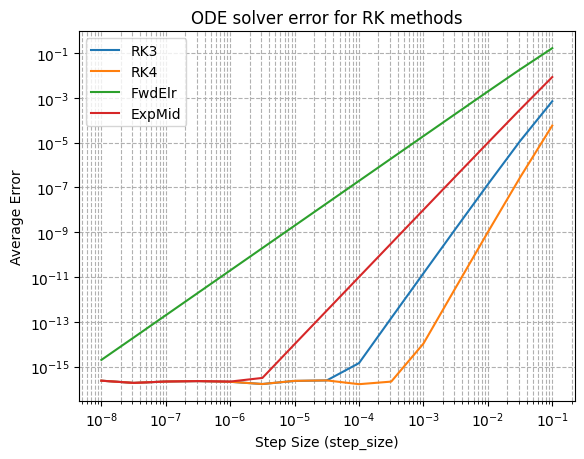

In [9]:
ode = bortz_ode
solution = solution_bortz
# Remove Variable solver
solver_dict = dict(rk_solver_dict.items() - [("Variable", rk_solver_dict["Variable"])])

df = quantify_solver(ode, solution, solver_dict, t=np.random.uniform(0, 0.1, 20))
plot_solver_performance(df)

### Runge-Kutta Munthe-Kaas Solver
For Lie-Group ODEs, the differential equation separates as the product of two terms: the current angle $\phi$, and the time-varying rate $\omega$. Instead of supplying the complete ODE to the solver ${f : \mathbb{R}\times \mathbb{R}^n\rightarrow \mathbb{R}^n}$, as a traditional RK-method, we can simply supply ${\omega : \mathbb{R}\rightarrow \mathbb{R}^n}$. The latter approach is referred to as RKMK methods {cite}`iserles2000lie`.

Adjusting the solver arguments necessitates re-constructing our solver dictionary.

In [10]:
# Create dictionary of ode solvers
rkmk_solver_dict = {}
tableau = ["FwdElr", "ExpMid", "RK3", "RK4"]
for tableau_ in tableau:
    # Define solver for this tableau
    if tableau_ in butcher_tableaux:

        def ivp_solve(f, t, step_size, y_t, tableau=tableau_) -> np.ndarray:
            y = rkmk_fixed(f, t, step_size, y_t, tableau=butcher_tableaux[tableau])
            return y

    else:
        raise ValueError("Unknown tableau: %s" % tableau_)

    rkmk_solver_dict[tableau_] = ivp_solve

We can now score the RKMK solvers using the same verifier method. The difference is that we supply $\omega$ instead of the prior ODE as the functional. We expect the same improvement in solution quality with solver order.

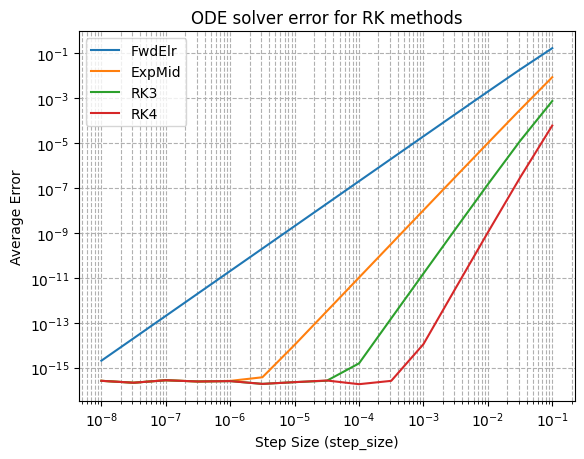

In [11]:
f = eval_omega  # Note: this is a function, not an ODE
solution = solution_bortz
solver_dict = rkmk_solver_dict

df = quantify_solver(f, solution, solver_dict, t=np.random.uniform(0, 0.1, 20))
plot_solver_performance(df)

The distinction here is subtle. One (traditional) approach to propagating attitude is to form an ODE by building-in angular rate. In this case, the angular rate effects time-variability in the differential equation. Alternatively, only angular rate is provided as a functional to the RKMK solver.  The full ODE is not required as the form of the ODE is presumed by the RKMK solver. RKMK methods are a natural fit for directly incorporating inertial measurements in vehicle state propagation.